In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input

In [2]:
import numpy as np

In [3]:
from IPython.display import Image

# Считывание изображений и создание генераторов

In [4]:
# Папка с изображениями (учебная выборка):
folder = 'traffic_lights_images'

In [5]:
# Папка с тестовыми изображениями:
test_folder = 'traffic_lights_images_test'

In [6]:
# Создаем генератор учебных изображений:
train_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.
                                   preprocess_input).flow_from_directory(directory=folder,
                                                                        target_size=(224, 224),
                                                                        class_mode='categorical',
                                                                        batch_size=15)

Found 45 images belonging to 3 classes.


In [7]:
# Создаем генератор тестовых изображений:
test_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.
                                   preprocess_input).flow_from_directory(directory=test_folder,
                                                                        target_size=(224, 224),
                                                                        class_mode='categorical',
                                                                        batch_size=9)

Found 9 images belonging to 3 classes.


# Переобучение готовой модели ResNet50

In [8]:
# Скачиваем модель:
resnet_model = ResNet50(weights="imagenet")

In [9]:
# Сведения о модели:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

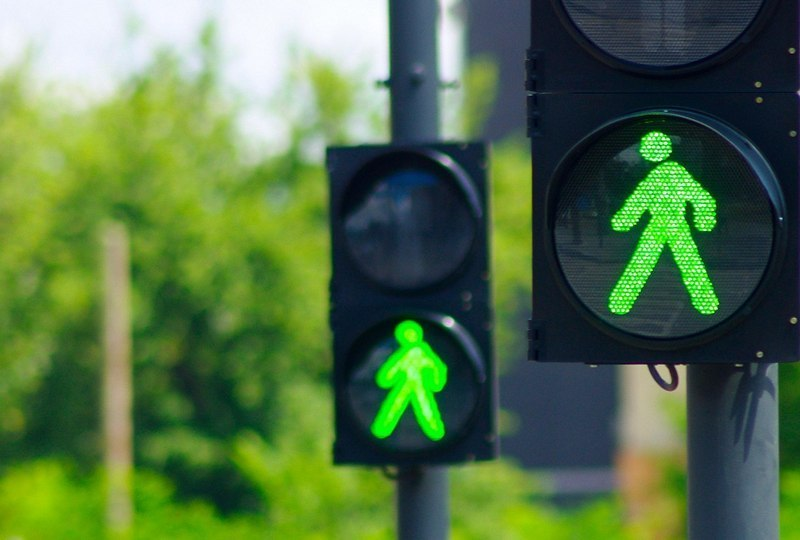

In [10]:
# Берем изображение из тестовой выборки:
Image(filename='1.jpg', width=300, height=200)

In [11]:
# Тестируем модель на одном изображении:
img = load_img('1.jpg', target_size=(224, 224))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = resnet_model.predict(x)
# print('Predicted:', decode_predictions(preds, top=3)[0])

In [12]:
for prediction in decode_predictions(preds)[0]:
    print(f'{prediction[1]}: {prediction[2]}')

traffic_light: 0.9953731894493103
parking_meter: 0.0026583801954984665
loudspeaker: 0.0010726056061685085
oscilloscope: 0.00028493706486187875
magnetic_compass: 0.00026892710593529046


In [13]:
# Создаем новую модель на основе ResNet50, заменяя последний слой:
last_layer = resnet_model.get_layer("avg_pool")  # Это предпоследний слой
resnet_layers = tf.keras.Model(inputs=resnet_model.inputs, outputs=last_layer.output)

In [14]:
resnet_layers.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [15]:
# Инициализируем новую модель:
new_model = Sequential()
new_model.add(resnet_layers)
new_model.add(Dense(3, activation="softmax"))

In [16]:
# Делаем все слои кроме последних 3 блоков необучаемыми
# (также можно сделать необучаемой всю эту часть новой модели):
new_model.layers[0].trainable=False
# for layer in new_model.layers[0].layers[-11:]:
#     layer.trainable = True

In [17]:
new_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [18]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 23,593,859
Trainable params: 6,147
Non-trainable params: 23,587,712
_________________________________________________________________


In [19]:
# Определяем параметры для остановки обучения при отсутствии улучшений
# точности на тестовой (валидационной) выборке:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [20]:
# Регулировка темпов обучения рекомендуется, когда мы обучаем слои готовой модели:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                                                 mode='max', cooldown=1, patience=2, min_lr=0)

In [21]:
# Обучаем модель, передавая в качестве валидационных данных изображения из тестовой выборки:
history = new_model.fit(train_generator, validation_data=test_generator,
                    epochs=20, verbose=2, callbacks=[reduce_lr, early_stop])

Epoch 1/20
3/3 - 17s - loss: 1.6025 - accuracy: 0.3111 - val_loss: 0.9384 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 2/20
3/3 - 14s - loss: 1.1853 - accuracy: 0.5111 - val_loss: 0.7160 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 3/20
3/3 - 15s - loss: 0.7350 - accuracy: 0.7111 - val_loss: 0.7303 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 4/20
3/3 - 14s - loss: 0.5653 - accuracy: 0.7778 - val_loss: 0.5819 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 5/20
3/3 - 14s - loss: 0.3769 - accuracy: 0.9111 - val_loss: 0.4631 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 6/20
3/3 - 14s - loss: 0.3089 - accuracy: 0.9333 - val_loss: 0.4279 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 7/20
3/3 - 14s - loss: 0.2567 - accuracy: 0.9556 - val_loss: 0.4232 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 8/20
3/3 - 14s - loss: 0.2454 - accuracy: 0.9778 - val_loss: 0.4167 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 9/20
3/3 - 15s - loss: 0.2362 - accuracy: 0.9778 - val_loss: 0.4160 - val_accuracy: 0.6667 - lr: 1.0000e-0

In [22]:
# Оцениваем точность модели:
loss, accuracy = new_model.evaluate(test_generator, verbose=2)
print(f'Точность модели на тестовой выборке: {accuracy}')

1/1 - 0s - loss: 0.5819 - accuracy: 0.8889
Точность модели на тестовой выборке: 0.8888888955116272


In [23]:
# Делаем прогноз на тестовой выборке:
prediction = new_model.predict(test_generator)

In [24]:
# Имена классов в виде списка:
class_names = list(test_generator.class_indices)

In [25]:
# Выводим прогноз в виде наименований классов:
print('Прогноз модели:')
for ind, color in enumerate(prediction):
    # Выбираем из каждого прогноза индекс элемента
    # с наибольшим значением (наиболее вероятный класс):
    print(f'№{ind} - {class_names[np.argmax(color)]}')

Прогноз модели:
№0 - green
№1 - green
№2 - yellow
№3 - green
№4 - yellow
№5 - yellow
№6 - green
№7 - red
№8 - red


In [26]:
# Оценка единичного изображения:
class_names[np.argmax(new_model.predict(x))]

'green'